<a href="https://colab.research.google.com/github/zuzka05/stat_learn/blob/main/video1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's Build a Quant Trading Strategy

## Video 1: Build a ML Model in PyTorch

In [1]:
# https://github.com/memlabs-research/build-a-quant-trading-strategy

In [2]:
# y_hat = model(x)
#Prediction that takes inputs

# orders = strategy(y_hat)
#Take the predictions to create order, bias orders based on predictions to ensure inventory on the right side

# execute(orders)
#Send the orders to exchange

In [3]:
# regression model => BTCUSDT => future log return
#Real outputs number

#API and order book easy to collect on BTC

In [4]:
import os
print(os.getcwd())

/content


In [5]:
!pip install "vegafusion[embed]>=1.5.0" "vl-convert-python>=1.6.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 81.0 MB/s eta 0:00:00


In [6]:
# Force reload of altair
import importlib
import altair as alt
importlib.reload(alt)

<module 'altair' from '/usr/local/lib/python3.12/dist-packages/altair/__init__.py'>

In [7]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data, times series
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  (to calculate weight and bias)
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities

In [8]:
!git clone https://github.com/memlabs-research/build-a-quant-trading-strategy.git
import sys
sys.path.append('/content/build-a-quant-trading-strategy')

from research import *
from binance import *

Cloning into 'build-a-quant-trading-strategy'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 113 (delta 63), reused 78 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 2.46 MiB | 9.61 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [9]:
#Make sure the results are within a certain distance from each other
research.set_seed(42)

In [10]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)  # Show all columns

polars.config.Config

In [11]:
#Research parameters
# Trading pair symbol
sym = 'BTCUSDT'
# time horizon of time series (time interval)
#the interval for our time series
time_interval = '1h'
# Max number of auto-regressive lags
# Predict the future log return based on the past one
max_lags = 4
# Forecast horizon in steps
#Time interval is 1 hour
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)

In [12]:
# old version that's in the video that should no longer used
# binance.download_trades(sym, hist_data_window)

# new version that downloads just the data showed in the video
start_date = datetime(2025, 9, 29, 0, 0)
end_date = datetime(2025, 10, 9, 0, 0)
binance.download_date_range(sym, start_date, end_date)

In [13]:
# this is the old version that's in the vide
# ts = research.load_ohlc_timeseries(sym, time_interval)
#stream it itervatively to build times series

# this version allows to get the same results in the video by fixing date range
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)
ts

Loading BTCUSDT: 100%|██████████| 11/11 [00:04<00:00,  2.75day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2025-09-29 00:00:00,112119.7,112269.3,111916.0,112211.2
2025-09-29 01:00:00,112211.2,112266.2,111652.7,111800.7
2025-09-29 02:00:00,111800.7,111975.5,111562.0,111690.8
2025-09-29 03:00:00,111690.8,111817.9,111517.3,111817.9
2025-09-29 04:00:00,111817.9,111860.0,111692.3,111752.7
…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8


In [14]:
#TS of the medium price, pass polar expressions
research.load_timeseries_range(sym, time_interval, start_date, end_date, pl.col('price').quantile(0.5).alias('price_median'))

Loading BTCUSDT: 100%|██████████| 11/11 [00:04<00:00,  2.56day/s]


datetime,price_median
datetime[μs],f64
2025-09-29 00:00:00,112100.0
2025-09-29 01:00:00,111990.7
2025-09-29 02:00:00,111737.7
2025-09-29 03:00:00,111661.2
2025-09-29 04:00:00,111780.4
…,…
2025-10-09 19:00:00,120839.8
2025-10-09 20:00:00,120942.8
2025-10-09 21:00:00,121300.7


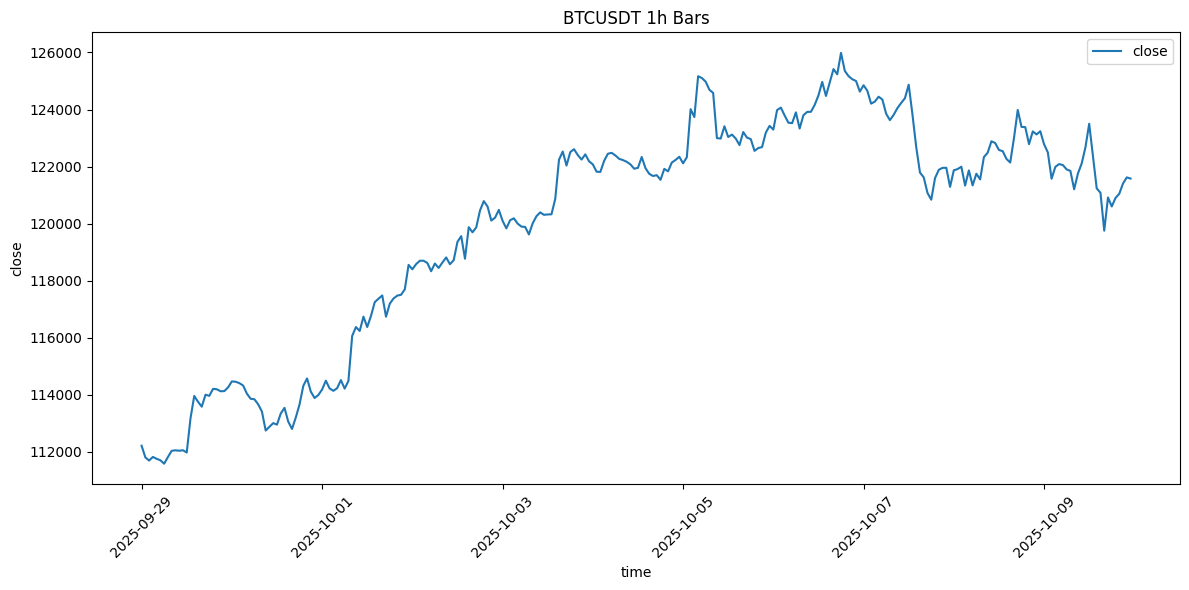

In [15]:
#Plot static ts, column and time interval
research.plot_static_timeseries(ts, sym, 'close', time_interval)

In [16]:
#Increase the allowance to display large datasets
#Dynamic chart
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

### Feature Engineering

In [17]:
#Features - What we are going to be predicting
#Predict log returns

In [18]:
price_time_series = pl.DataFrame({'price':[100.0,120.0,100.0]})
research.plot_column(price_time_series, 'price')

alt.Chart(...)

In [19]:
#Create price movements series
#Take this price series and add columns to it
#Take the previous price which we get by shifting then divide by the previous price
#Take the price and divide it by the previous price, take the log of it - log return
#Returns are unitless, they're asymmetric

#Log returns are time-additive and symmetric and unitless
#How much money would I make if invest $100?
#Add delta - they can be added so you get the total net return and TR

In [20]:
price_time_series.with_columns(
    pl.col('price').diff().alias('delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('return'),
    (pl.col('price')/pl.col('price').shift()).log().alias('log_return'),
)

price,delta,return,log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


### Create target and lagged features

In [21]:
#Create targets - what we're going to be predicting

In [22]:
#create target, add column
#by default it shifts by 1, but we add forecast_horizon by which it will be shifted
#the first row is empty, no previous points
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))
ts

datetime,open,high,low,close,close_log_return
datetime[μs],f64,f64,f64,f64,f64
2025-09-29 00:00:00,112119.7,112269.3,111916.0,112211.2,null
2025-09-29 01:00:00,112211.2,112266.2,111652.7,111800.7,-0.003665
2025-09-29 02:00:00,111800.7,111975.5,111562.0,111690.8,-0.000983
2025-09-29 03:00:00,111690.8,111817.9,111517.3,111817.9,0.001137
2025-09-29 04:00:00,111817.9,111860.0,111692.3,111752.7,-0.000583
…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989


In [23]:
#Target as a variable to create lagged feature
#Shift - move the lag by 1

In [24]:
target = 'close_log_return'
lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias(f'{target}_lag_1'),
    lr.shift(forecast_horizon * 2).alias(f'{target}_lag_2'),
    lr.shift(forecast_horizon * 3).alias(f'{target}_lag_3'),
    lr.shift(forecast_horizon * 4).alias(f'{target}_lag_4'),
)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-09-29 00:00:00,112119.7,112269.3,111916.0,112211.2,null,null,null,null,null
2025-09-29 01:00:00,112211.2,112266.2,111652.7,111800.7,-0.003665,null,null,null,null
2025-09-29 02:00:00,111800.7,111975.5,111562.0,111690.8,-0.000983,-0.003665,null,null,null
2025-09-29 03:00:00,111690.8,111817.9,111517.3,111817.9,0.001137,-0.000983,-0.003665,null,null
2025-09-29 04:00:00,111817.9,111860.0,111692.3,111752.7,-0.000583,0.001137,-0.000983,-0.003665,null
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [25]:
#We can add lags in a cleaner way

In [26]:
ts = research.add_lags(ts, target, max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-09-29 00:00:00,112119.7,112269.3,111916.0,112211.2,null,null,null,null,null
2025-09-29 01:00:00,112211.2,112266.2,111652.7,111800.7,-0.003665,null,null,null,null
2025-09-29 02:00:00,111800.7,111975.5,111562.0,111690.8,-0.000983,-0.003665,null,null,null
2025-09-29 03:00:00,111690.8,111817.9,111517.3,111817.9,0.001137,-0.000983,-0.003665,null,null
2025-09-29 04:00:00,111817.9,111860.0,111692.3,111752.7,-0.000583,0.001137,-0.000983,-0.003665,null
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [27]:
#it is important to drop all nulls

In [28]:
ts = ts.drop_nulls()

In [29]:
#We log_returns and we have a ND, with raw price is a multimodal distribution
#ML makes no assumptions about data (prices)

In [30]:
research.plot_distribution(ts, target, no_bins = 100)

alt.Chart(...)

In [31]:
research.plot_distribution(ts, 'close', no_bins = 100)

alt.Chart(...)

### Build Model

In [32]:
#More intepretable and better generalization
#Use a super-constructor
#Input features = the number of columns in your feature matrix (X) - len(features) = number of features

#features = ['rsi', 'ma_20', 'volatility', 'volume', 'prev_return']
# len(features) = 5

#Then input_features = 5, meaning your model expects 5 numbers per prediction:
#X_train.shape = (1000, 5)  # 1000 samples, 5 features each

In [33]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

### Complexity of the model

In [34]:
#1 input, 1 output, bias is True. Weight and the bias

In [35]:
input_features = 1

linear_model = LinearModel(input_features)

research.print_model_info(linear_model, "Linear Model")
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

In [36]:
# y = w * x + b

### Split by time

In [37]:
#!!! Very important step
#Often we get data leakage here, don't leak any data that is not known

In [38]:
#AR1 - future return predicted on the current return
#We need some test data - most recent
#The oldest data for training
#Train-test split in scikit is to shuffle future and past
#Do it from scratch, not to use the library
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

In [39]:
len(ts)

259

In [40]:
int(len(ts) * test_size)

64

In [41]:
#to split the data by time, we split it by index
split_idx = int(len(ts) * (1-test_size))
split_idx

194

In [42]:
#split ts to train and test data
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [43]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-09-29 05:00:00,111752.6,111769.0,111508.7,111699.9,-0.000473,-0.000583,0.001137,-0.000983,-0.003665
2025-09-29 06:00:00,111700.0,111811.1,111561.3,111580.1,-0.001073,-0.000473,-0.000583,0.001137,-0.000983
2025-09-29 07:00:00,111580.0,111814.8,111501.0,111814.7,0.0021,-0.001073,-0.000473,-0.000583,0.001137
2025-09-29 08:00:00,111814.8,112381.3,111814.7,112033.4,0.001954,0.0021,-0.001073,-0.000473,-0.000583
2025-09-29 09:00:00,112033.5,112166.2,111927.4,112050.0,0.000148,0.001954,0.0021,-0.001073,-0.000473
…,…,…,…,…,…,…,…,…,…
2025-10-07 02:00:00,124657.9,124658.0,124100.8,124205.5,-0.003637,-0.001541,0.001778,-0.002975,-0.000497
2025-10-07 03:00:00,124205.6,124527.7,124055.0,124277.7,0.000581,-0.003637,-0.001541,0.001778,-0.002975
2025-10-07 04:00:00,124277.8,124631.9,124056.1,124449.8,0.001384,0.000581,-0.003637,-0.001541,0.001778


In [44]:
ts_test

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-10-07 07:00:00,123852.6,124009.9,123503.9,123627.1,-0.001822,-0.004,-0.00081,0.001384,0.000581
2025-10-07 08:00:00,123627.1,123948.7,123261.6,123813.1,0.001503,-0.001822,-0.004,-0.00081,0.001384
2025-10-07 09:00:00,123813.1,124199.2,123799.5,124049.2,0.001905,0.001503,-0.001822,-0.004,-0.00081
2025-10-07 10:00:00,124049.2,124372.0,123951.6,124229.9,0.001456,0.001905,0.001503,-0.001822,-0.004
2025-10-07 11:00:00,124229.9,124471.4,124110.7,124397.2,0.001346,0.001456,0.001905,0.001503,-0.001822
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [45]:
#Convert the data to torch tensors

In [46]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
#Convert it to float64 tensor, no need to convert back to float32
X_test = ts_test[features].to_torch().float()
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [47]:
X_train

tensor([[-5.8326e-04],
        [-4.7258e-04],
        [-1.0731e-03],
        [ 2.1003e-03],
        [ 1.9540e-03],
        [ 1.4816e-04],
        [-1.3477e-04],
        [ 1.5262e-04],
        [-7.0885e-04],
        [ 1.0621e-02],
        [ 6.9433e-03],
        [-1.7979e-03],
        [-1.5114e-03],
        [ 3.6893e-03],
        [-3.5182e-04],
        [ 2.1467e-03],
        [-1.2697e-04],
        [-6.0794e-04],
        [ 4.3812e-05],
        [ 1.1489e-03],
        [ 1.8249e-03],
        [-9.4356e-05],
        [-4.3258e-04],
        [-7.3450e-04],
        [-2.4899e-03],
        [-1.5823e-03],
        [-1.4669e-04],
        [-1.5631e-03],
        [-2.2301e-03],
        [-5.8907e-03],
        [ 1.1825e-03],
        [ 1.1263e-03],
        [-4.7532e-04],
        [ 3.4354e-03],
        [ 1.7701e-03],
        [-4.2728e-03],
        [-2.2740e-03],
        [ 3.5416e-03],
        [ 4.0484e-03],
        [ 5.7122e-03],
        [ 2.2781e-03],
        [-4.0389e-03],
        [-1.9703e-03],
        [ 9

In [48]:
#2-dimensional tensor
#Rows and features
#1st dimension is row and 2nd dimension is feature
X_train.shape

torch.Size([194, 1])

In [49]:
#Column vector - 1-dimensional tensor
#Convert it to 2-dimensional tensor
y_train

tensor([-4.7258e-04, -1.0731e-03,  2.1003e-03,  1.9540e-03,  1.4816e-04,
        -1.3477e-04,  1.5262e-04, -7.0885e-04,  1.0621e-02,  6.9433e-03,
        -1.7979e-03, -1.5114e-03,  3.6893e-03, -3.5182e-04,  2.1467e-03,
        -1.2697e-04, -6.0794e-04,  4.3812e-05,  1.1489e-03,  1.8249e-03,
        -9.4356e-05, -4.3258e-04, -7.3450e-04, -2.4899e-03, -1.5823e-03,
        -1.4669e-04, -1.5631e-03, -2.2301e-03, -5.8907e-03,  1.1825e-03,
         1.1263e-03, -4.7532e-04,  3.4354e-03,  1.7701e-03, -4.2728e-03,
        -2.2740e-03,  3.5416e-03,  4.0484e-03,  5.7122e-03,  2.2781e-03,
        -4.0389e-03, -1.9703e-03,  9.2508e-04,  1.6856e-03,  2.7157e-03,
        -2.3838e-03, -7.2781e-04,  8.0486e-04,  2.4797e-03, -2.6110e-03,
         2.3437e-03,  1.3704e-02,  2.6838e-03, -1.1934e-03,  4.3199e-03,
        -3.1153e-03,  3.3354e-03,  4.1264e-03,  1.0323e-03,  9.6829e-04,
        -6.3694e-03,  3.9166e-03,  1.5501e-03,  8.5587e-04,  2.4343e-04,
         1.6378e-03,  7.2517e-03, -1.3117e-03,  1.5

In [50]:
y_train.shape

torch.Size([194])

In [51]:
#it didn't change the data it just changed the shape of the tensor
#now, it's a row vector
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-4.7258e-04],
        [-1.0731e-03],
        [ 2.1003e-03],
        [ 1.9540e-03],
        [ 1.4816e-04],
        [-1.3477e-04],
        [ 1.5262e-04],
        [-7.0885e-04],
        [ 1.0621e-02],
        [ 6.9433e-03],
        [-1.7979e-03],
        [-1.5114e-03],
        [ 3.6893e-03],
        [-3.5182e-04],
        [ 2.1467e-03],
        [-1.2697e-04],
        [-6.0794e-04],
        [ 4.3812e-05],
        [ 1.1489e-03],
        [ 1.8249e-03],
        [-9.4356e-05],
        [-4.3258e-04],
        [-7.3450e-04],
        [-2.4899e-03],
        [-1.5823e-03],
        [-1.4669e-04],
        [-1.5631e-03],
        [-2.2301e-03],
        [-5.8907e-03],
        [ 1.1825e-03],
        [ 1.1263e-03],
        [-4.7532e-04],
        [ 3.4354e-03],
        [ 1.7701e-03],
        [-4.2728e-03],
        [-2.2740e-03],
        [ 3.5416e-03],
        [ 4.0484e-03],
        [ 5.7122e-03],
        [ 2.2781e-03],
        [-4.0389e-03],
        [-1.9703e-03],
        [ 9.2508e-04],
        [ 1

In [52]:
y_train.shape

torch.Size([194, 1])

In [53]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[-1.8224e-03],
        [ 1.5034e-03],
        [ 1.9051e-03],
        [ 1.4556e-03],
        [ 1.3458e-03],
        [ 3.7895e-03],
        [-8.3967e-03],
        [-9.2606e-03],
        [-7.3277e-03],
        [-1.3705e-03],
        [-4.5193e-03],
        [-1.9437e-03],
        [ 6.2335e-03],
        [ 2.3969e-03],
        [ 5.6349e-04],
        [ 2.2139e-05],
        [-5.5114e-03],
        [ 4.7904e-03],
        [ 3.4785e-04],
        [ 6.8633e-04],
        [-5.4404e-03],
        [ 4.3775e-03],
        [-4.3371e-03],
        [ 3.3815e-03],
        [-1.6326e-03],
        [ 6.4146e-03],
        [ 1.2450e-03],
        [ 3.2661e-03],
        [-4.8838e-04],
        [-2.0000e-03],
        [-3.2555e-04],
        [-2.2221e-03],
        [-1.0499e-03],
        [ 7.0148e-03],
        [ 7.9811e-03],
        [-4.8162e-03],
        [-6.4837e-05],
        [-4.8520e-03],
        [ 3.6323e-03],
        [-8.5486e-04],
        [ 9.0435e-04],
        [-3.7030e-03],
        [-2.3272e-03],
        [-7

In [54]:
#Now they're both 2-D tensors

In [55]:
research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[-5.8326e-04],
         [-4.7258e-04],
         [-1.0731e-03],
         [ 2.1003e-03],
         [ 1.9540e-03],
         [ 1.4816e-04],
         [-1.3477e-04],
         [ 1.5262e-04],
         [-7.0885e-04],
         [ 1.0621e-02],
         [ 6.9433e-03],
         [-1.7979e-03],
         [-1.5114e-03],
         [ 3.6893e-03],
         [-3.5182e-04],
         [ 2.1467e-03],
         [-1.2697e-04],
         [-6.0794e-04],
         [ 4.3812e-05],
         [ 1.1489e-03],
         [ 1.8249e-03],
         [-9.4356e-05],
         [-4.3258e-04],
         [-7.3450e-04],
         [-2.4899e-03],
         [-1.5823e-03],
         [-1.4669e-04],
         [-1.5631e-03],
         [-2.2301e-03],
         [-5.8907e-03],
         [ 1.1825e-03],
         [ 1.1263e-03],
         [-4.7532e-04],
         [ 3.4354e-03],
         [ 1.7701e-03],
         [-4.2728e-03],
         [-2.2740e-03],
         [ 3.5416e-03],
         [ 4.0484e-03],
         [ 5.7122e-03],
         [ 2.2781e-03],
         [-4.038

### Batch Gradient Descent

In [56]:
#Start learning, learn what the most optimal parameters are
#In practice mini batch gradient descent
#Here just use one batch, load all the data together

In [57]:
#hyperparameters - specific to the training
#lr - how much we adjust the weight by
#lr too large, weights increase by large amounts
#weights too small, change very slowly, then you can have more epochs
#that depends on the distribution of the data

#We want to experiment with the loss
#Outliers, abnormal price movements - it can have an impact on performance
#Optimizer -> Adam - it adapts the parameters of the optimization


In [58]:
# hyperparameters
no_epochs = 1000 * 5
lr = 0.0005

# create model
model = LinearModel(len(features))
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

print("\nTraining model...")

for epoch in range(no_epochs):
    # forward pass - passing all of the data
    y_hat = model(X_train)
    # ML - minimize the Loss, wuantified as MSE
    #Don't use any test data
    loss = criterion(y_hat, y_train)

    # backward pass
    # update the weights according to weight and the loss
    # zero out the gradients, otherwise it will cumulate the gradients
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimizer.step()        # 3. update weights

    # check for improvement
    train_loss = loss.item()

    # logging
    # see how our training is doing, if it is overfitting or stop prematurely - if not learning
    # we can exit prematurely if there's no improvement in the loss
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}")

#what is our weight and bias that is learned
print("\nLearned parameters")

#we're only interested in parameters if they're learnable
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
# it turns off certain training layers, dropout
model.eval()
#tell torch no longer calculate gradients
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    #compare test and train loss - if big deviation most likely overfitting
    print(f"\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}")



Training model...
Epoch [500/5000], Loss: 0.467916
Epoch [1000/5000], Loss: 0.233912
Epoch [1500/5000], Loss: 0.101288
Epoch [2000/5000], Loss: 0.035919
Epoch [2500/5000], Loss: 0.009666
Epoch [3000/5000], Loss: 0.001798
Epoch [3500/5000], Loss: 0.000221
Epoch [4000/5000], Loss: 0.000034
Epoch [4500/5000], Loss: 0.000022
Epoch [5000/5000], Loss: 0.000021

Learned parameters
linear.weight:
[[-0.97633487]]
linear.bias:
[0.00112174]

Test Loss: 0.000043, Train Loss: 0.000021


In [59]:
#The loss hasn't changed - terminate when no improvement
#Weight is negative - it is a MR model
#If the previous log return is positive then it flips the sign
#Test loss vs train loss - no huge deviation
#It doesn't tell us how profitable the strategy is, only that is minimize by a certain amount


### Test Trading Peformance

In [60]:
#with the test data, create some trade results
#create a new dataframe
#2D column vector, we want to squeeze it to 1 dimensional tensor
#y is the actual value, it is our y test
#with each trade did we win or not

#If we win the trade - look at y_hat - calculate the sign
#If this equal the sign of our actual value - then it is won
#The sign is our signal
#If we predict it's gonna go down '-1' gonna go up it is '1'
#calculate each trade's log return
#take the signal multiply by our y
#if we predict it's gonna go down, and it actually goes down, then it turns it into positive
#that's how we map it into train results
#build the equity curve by summing the log returns

#performance curve is a cummulative sum

In [61]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.005027,-0.001822,false,1.0,-0.001822,-0.001822
0.002901,0.001503,true,1.0,0.001503,-0.000319
-0.000346,0.001905,false,-1.0,-0.001905,-0.002224
-0.000738,0.001456,false,-1.0,-0.001456,-0.00368
-0.000299,0.001346,false,-1.0,-0.001346,-0.005025
…,…,…,…,…,…
0.003673,0.002465,true,1.0,0.002465,-0.037981
-0.001285,0.001222,false,-1.0,-0.001222,-0.039202
-0.000071,0.002989,false,-1.0,-0.002989,-0.042192


In [62]:
#Plot the equity curve
#It's hovering, we have some drawdowns, performance around 0
#Drawdown - peak of the equity curve - till the bottom

In [63]:
research.plot_column(trade_results, 'equity_curve')

alt.Chart(...)

In [64]:
#With cum_max it tracks the peak when it goes through times series
#It shows us at each point what the drawdown is
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.005027,-0.001822,false,1.0,-0.001822,-0.001822,0.0
0.002901,0.001503,true,1.0,0.001503,-0.000319,0.0
-0.000346,0.001905,false,-1.0,-0.001905,-0.002224,-0.001905
-0.000738,0.001456,false,-1.0,-0.001456,-0.00368,-0.003361
-0.000299,0.001346,false,-1.0,-0.001346,-0.005025,-0.004707
…,…,…,…,…,…,…
0.003673,0.002465,true,1.0,0.002465,-0.037981,-0.037662
-0.001285,0.001222,false,-1.0,-0.001222,-0.039202,-0.038883
-0.000071,0.002989,false,-1.0,-0.002989,-0.042192,-0.041873


In [65]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.05240877345204353

In [66]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.05105911429153809)

In [67]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-51.05911429153809)

In [68]:

win_rate = trade_results['is_won'].mean()
win_rate

0.36923076923076925

In [69]:
#calculate the expected value

In [70]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss
ev

-0.0006708221705943845

In [71]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

-0.04360344260931015

In [72]:

compound_return = np.exp(total_log_return)
compound_return

np.float64(0.9573335198915995)

In [73]:
#Probably the negative value when TCs added
1000*compound_return

np.float64(957.3335198915995)

In [74]:
#the lowest peak of our equity curve
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.052727751433849335

In [75]:
#the highest point on the equity curve
equity_peak = trade_results['equity_curve'].max()
equity_peak

-0.00031897833105176687

In [76]:
#Measure of risk
std = trade_results['trade_log_return'].std()
std

0.004474930930882692

In [77]:
#annualized_rate -> square root of the number of the trading periods
sharpe = ev / std * annualized_rate
sharpe

np.float64(-14.030499225450592)

In [78]:
#Dictionary of performance metrics
#Compare the models against each other in a df
#Then sort by metrics and pick which one is best

In [79]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 65,
 'win_rate': 0.36923076923076925,
 'avg_win': 0.00382528394190255,
 'avg_loss': -0.0033026891632755174,
 'best_trade': 0.009669008664786816,
 'worst_trade': -0.01102275587618351,
 'ev': -0.0006708221705943845,
 'std': 0.004474930930882692,
 'total_log_return': -0.04360344260931015,
 'compound_return': np.float64(0.9573335198915995),
 'max_drawdown': -0.05240877345204353,
 'equity_trough': -0.052727751433849335,
 'equity_peak': -0.00031897833105176687,
 'sharpe': np.float64(-14.030499225450594)}

In [80]:
#we looked at lag_1 now we look at lag_2, use linear model
#pass in the time series, the features the target, the model
#you can pass a different optimizer and a different loss function
#Sharp is better
#MR is negative on the weight
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
perf = research.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)
perf

{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 65,
 'win_rate': 0.4307692307692308,
 'avg_win': 0.0038328934928618503,
 'avg_loss': -0.0032404338513466377,
 'best_trade': 0.009669008664786816,
 'worst_trade': -0.01102275587618351,
 'ev': -0.00019346207230298124,
 'std': 0.004521507304161787,
 'total_log_return': -0.01257503405213356,
 'compound_return': np.float64(0.987503701309729),
 'max_drawdown': -0.03688977286219597,
 'equity_trough': -0.024237344041466713,
 'equity_peak': 0.01265242975205183,
 'sharpe': np.float64(-4.0046507965433475),
 'weights': '[-0.219211]',
 'biases': '0.00012474803952500224'}

In [81]:
#Compare different lags between each other
#Benchmark each feature
# itertools - look at different combinations of 2-dimensional features space
# combos - experiment - looking at different features

#loss function is stateless - minimum absolute error L1
#this is good if we have outliers in our data

#lag2 has the highest SR - it looses more than it wins
#avg_win is higher than avg_loss -> a small tiny edge
#It has a drawdon of 20%, it gives a CR of 25%
#It goes into a negative equity
#It's a MR -> it has a negative coefficient

In [82]:
import itertools

benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))

for features in combos:
    model = LinearModel(len(features))
    benchmarks.append(research.benchmark_reg_model(ts, list(features), target, model, annualized_rate, test_size=test_size, no_epochs=200, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe', descending=True)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",65,0.415385,0.004005,-0.003134,0.009669,-0.011023,-0.000169,0.004523,-0.01097,0.98909,-0.031236,-0.018583,0.012652,-3.492702,"""[-0.1598488]""","""0.00018463509331922978"""
"""close_log_return_lag_1""","""close_log_return""",65,0.523077,0.003093,-0.003937,0.009261,-0.011023,-0.00026,0.004518,-0.016889,0.983253,-0.053001,-0.024976,0.028024,-5.382508,"""[0.01464012]""","""4.838933818973601e-05"""
"""close_log_return_lag_4""","""close_log_return""",65,0.476923,0.003309,-0.003666,0.009669,-0.011023,-0.000339,0.004513,-0.022065,0.978177,-0.039406,-0.031229,0.008177,-7.040406,"""[-0.0182553]""","""0.00012712497846223414"""
"""close_log_return_lag_3""","""close_log_return""",65,0.307692,0.002991,-0.00372,0.011023,-0.009669,-0.001655,0.004207,-0.107576,0.898009,-0.110443,-0.108987,0.001456,-36.818342,"""[0.0470098]""","""5.828848225064576e-05"""


In [ ]:
#Look at the correlations between lags
#Correlation between close_log_return and lag_2 is not the strongest
#It doesn't always map, the trading performance to the strongest correlation
#especially when customizing the loss function and learning algo

In [83]:
research.auto_reg_corr_matrx(ts, target, max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,0.005158,0.023726,-0.030922,-0.063624
0.005158,1.0,0.005213,0.024588,-0.029647
0.023726,0.005213,1.0,0.003821,0.023236
-0.030922,0.024588,0.003821,1.0,0.004584
-0.063624,-0.029647,0.023236,0.004584,1.0


In [ ]:
#Loss - MAE
#Larger slumps in equity curve can be dangerous when choosing big leverage


In [84]:
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())

research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

## Add Transaction Fees

In [ ]:
#Maker fee: fee for providing liquidity
#Taker fee is higher as you're removing liquidity
#We want roundtrip - for each row we make 2 trades - factor this in


In [105]:
maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1 - 2 * taker_fee)

#Each row will have a constant value - tx_fee_log
model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
#Calculate net log return - calculate net return and add to it the transaction fee
model_trades = model_trades.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
#The cumulative sum: it is the equity curve but the net version
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))

model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,trade_log_return_net_maker,trade_log_return_net_taker,equity_curve_net_maker,equity_curve_net_taker,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64
0.001898,-0.027085,false,1.0,-0.027085,-0.027085,0.0,-9.237426,-8.138813,-9.237426,-8.138813,-0.0006,-0.027685,-0.027685
-0.012716,0.001761,false,-1.0,-0.001761,-0.028846,-0.001761,-9.212102,-8.113489,-18.449528,-16.252302,-0.0006,-0.002361,-0.030047
0.006365,0.000425,true,1.0,0.000425,-0.028422,-0.001336,-9.209916,-8.111303,-27.659443,-24.363605,-0.0006,-0.000176,-0.030222
-0.001198,0.012186,false,-1.0,-0.012186,-0.040608,-0.013523,-9.222527,-8.123914,-36.881969,-32.487518,-0.0006,-0.012786,-0.043009
0.008607,0.009398,true,1.0,0.009398,-0.03121,-0.004124,-9.200942,-8.102329,-46.082912,-40.589848,-0.0006,0.008798,-0.03421
0.005492,-0.006051,false,1.0,-0.006051,-0.037261,-0.010176,-9.216392,-8.117779,-55.299305,-48.707626,-0.0006,-0.006651,-0.040862
-0.00098,-0.009661,true,-1.0,0.009661,-0.0276,-0.000514,-9.200679,-8.102066,-64.499985,-56.809692,-0.0006,0.009061,-0.031801
-0.001285,0.005069,false,-1.0,-0.005069,-0.032669,-0.005584,-9.21541,-8.116797,-73.715393,-64.926491,-0.0006,-0.00567,-0.03747
0.005176,-0.014429,false,1.0,-0.014429,-0.047098,-0.020012,-9.22477,-8.126157,-82.940163,-73.05265,-0.0006,-0.015029,-0.052499


In [ ]:
#Stable negative returns - very low SR
#When we have transaction fees, it magnifies our losses and decreases our average win
#It is reducing our expected value
#Lower fees would be ok, even if we have an edge it would loose money
#It tells us, we can't trade on a 1H time basis
#The more you trade, the lower the fees

#Longer time horizons
#Maybe try to predict a 8H basis or 1day basis


In [86]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [87]:
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [88]:
#The statistics of performance didn't change
model_trades['is_won'].mean()

0.4153846153846154

In [89]:
#Add fees automatically - it gives 2 equity curves, one for the maker and one for the taker, compare them together
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net,trade_log_return_net_maker,trade_log_return_net_taker,equity_curve_net_maker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f32,f32,f32,f32
0.000314,-0.001822,false,1.0,-0.001822,-0.001822,0.0,-0.0006,-0.002423,-0.002423,-9.212163,-8.11355,-9.212163,-8.11355
0.000824,0.001503,true,1.0,0.001503,-0.000319,0.0,-0.0006,0.000903,-0.001519,-9.208838,-8.110225,-18.421001,-16.223774
0.000476,0.001905,true,1.0,0.001905,0.001586,0.0,-0.0006,0.001305,-0.000214,-9.208435,-8.109822,-27.629436,-24.333595
-0.000056,0.001456,false,-1.0,-0.001456,0.00013,-0.001456,-0.0006,-0.002056,-0.00227,-9.211796,-8.113183,-36.841232,-32.446777
-0.000121,0.001346,false,-1.0,-0.001346,-0.001215,-0.002801,-0.0006,-0.001946,-0.004216,-9.211686,-8.113073,-46.052917,-40.559853
…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.001363,0.002465,false,-1.0,-0.002465,-0.007791,-0.020443,-0.0006,-0.003065,-0.044402,-9.212805,-8.114192,-561.838562,-494.823029
0.000602,0.001222,true,1.0,0.001222,-0.006569,-0.019221,-0.0006,0.000622,-0.04378,-9.209119,-8.110506,-571.047668,-502.933533
-0.00021,0.002989,false,-1.0,-0.002989,-0.009558,-0.022211,-0.0006,-0.00359,-0.04737,-9.21333,-8.114717,-580.260986,-511.048248


In [ ]:
#It would be tedious to go back and change the params
#Now focus we time interval is 6h
#Rationale for achieving 8h, hopefully we make enough money
#when we add transaction fees it doesn't decrease our expected value

In [90]:
#generate 6-hourly time series
time_interval = '6h'
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)
ts


Loading BTCUSDT: 100%|██████████| 11/11 [00:04<00:00,  2.29day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2025-09-29 00:00:00,112119.7,112269.3,111508.7,111699.9
2025-09-29 06:00:00,111700.0,112381.3,111501.0,112052.0
2025-09-29 12:00:00,112052.0,114188.0,111844.3,114000.0
2025-09-29 18:00:00,114000.1,114377.2,113790.5,114257.1
2025-09-30 00:00:00,114257.1,114800.0,113777.8,113856.9
…,…,…,…,…
2025-10-08 18:00:00,123985.5,124169.2,122739.7,123237.5
2025-10-09 00:00:00,123237.4,123279.7,121411.8,122052.6
2025-10-09 06:00:00,122052.6,122777.0,121081.5,122672.9


In [91]:
#Add target and features
#We try to predict next point in times series, that maps to future log_return in 6 hours
no_lags = 3
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-09-29 00:00:00,112119.7,112269.3,111508.7,111699.9,null,null,null,null
2025-09-29 06:00:00,111700.0,112381.3,111501.0,112052.0,0.003147,null,null,null
2025-09-29 12:00:00,112052.0,114188.0,111844.3,114000.0,0.017235,0.003147,null,null
2025-09-29 18:00:00,114000.1,114377.2,113790.5,114257.1,0.002253,0.017235,0.003147,null
2025-09-30 00:00:00,114257.1,114800.0,113777.8,113856.9,-0.003509,0.002253,0.017235,0.003147
…,…,…,…,…,…,…,…,…
2025-10-08 18:00:00,123985.5,124169.2,122739.7,123237.5,-0.006051,0.009398,0.012186,0.000425
2025-10-09 00:00:00,123237.4,123279.7,121411.8,122052.6,-0.009661,-0.006051,0.009398,0.012186
2025-10-09 06:00:00,122052.6,122777.0,121081.5,122672.9,0.005069,-0.009661,-0.006051,0.009398


In [ ]:
#Good model - high SR 5, avg_win higher than avg_loss, win rate higher 0.5, high equity peak

In [92]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
#we pass the target - what we want to predict and then the feature pool
#loss function Huber Loss -> a mixture of MAE and MSE
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.HuberLoss())
#Common for intraday trading to have MR behavior

#That was the 2nd lag

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.10319985]""","""0.0031358369160443544"""
"""close_log_return_lag_2""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.15526278]""","""0.003387555480003357"""
"""close_log_return_lag_3""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.16497125]""","""0.003452524309977889"""


In [93]:
#Correlation of lags doesn't indicate trading performance - check yourself
research.auto_reg_corr_matrx(ts.drop_nulls(), target, no_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
f64,f64,f64,f64
1.0,-0.05014,-0.028071,-0.104462
-0.05014,1.0,-0.027179,-0.031405
-0.028071,-0.027179,1.0,-0.008797
-0.104462,-0.031405,-0.008797,1.0


In [94]:
#Instead of Huber Loss, MSE is more sensitive to outliers
#How change in the loss function changes the trading performance?
#A similar SR

research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.10283852]""","""0.003132148878648877"""
"""close_log_return_lag_2""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.15484929]""","""0.0033833493944257498"""
"""close_log_return_lag_3""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.16269225]""","""0.0034545629750937223"""


In [95]:
##Compare it with L1 loss function - it's even better because it handles outliers better - it doesn't penalize them as much as squared error does
#Compound return: 33%, this is the return on investment
#Equity trough - positive - never goes into a negative equity, peak is 28
#Quite a low drawdown
#Look at win rate and expected value (59% win rate, losses more severe than wins)
#It wins more so it gives us a more positive EV
#By experimenting with the different loss functions, found some with very high SR
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.L1Loss(), test_size=0.3)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",12,0.666667,0.005094,-0.013355,0.012186,-0.027085,-0.001056,0.011117,-0.012668,0.987412,-0.027085,-0.028943,0.000879,-8.888206,"""[-0.27135018]""","""0.002812412567436695"""
"""close_log_return_lag_1""","""close_log_return""",12,0.583333,0.004957,-0.011894,0.012186,-0.027085,-0.002064,0.010961,-0.024771,0.975534,-0.028387,-0.030245,-0.001858,-17.626067,"""[-0.12384734]""","""0.0028316532261669636"""
"""close_log_return_lag_3""","""close_log_return""",12,0.583333,0.004957,-0.011894,0.012186,-0.027085,-0.002064,0.010961,-0.024771,0.975534,-0.028387,-0.030245,-0.001858,-17.626067,"""[-0.17752045]""","""0.0032388996332883835"""


In [ ]:
#Look at equity curve and equity curve fees included
#Look at SR, the higher the more of a straight line the equity curve looks like with min drawdowns
#We can use much more leverage - less risk of liquidation
#Taking strategy is simpler

In [96]:
features = ['close_log_return_lag_1']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [ ]:
#Taker equity curve (it includes fees - make money still tradeable)
#It amplifies drawdown and decreases the expected value
#The more trade, the more trading volume, the better fees

In [97]:
research.plot_column(model_trades, 'equity_curve_net_taker')

alt.Chart(...)

In [ ]:
#Don't focus on a win rate - win 56%: positive statistical edge modelled as an EV

## Research 12 forecast horizon

In [98]:
time_interval = '12h'


In [99]:
no_lags = 4
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-09-29 00:00:00,112119.7,112269.3,111508.7,111699.9,null,null,null,null,null
2025-09-29 06:00:00,111700.0,112381.3,111501.0,112052.0,0.003147,null,null,null,null
2025-09-29 12:00:00,112052.0,114188.0,111844.3,114000.0,0.017235,0.003147,null,null,null
2025-09-29 18:00:00,114000.1,114377.2,113790.5,114257.1,0.002253,0.017235,0.003147,null,null
2025-09-30 00:00:00,114257.1,114800.0,113777.8,113856.9,-0.003509,0.002253,0.017235,0.003147,null
…,…,…,…,…,…,…,…,…,…
2025-10-08 18:00:00,123985.5,124169.2,122739.7,123237.5,-0.006051,0.009398,0.012186,0.000425,0.001761
2025-10-09 00:00:00,123237.4,123279.7,121411.8,122052.6,-0.009661,-0.006051,0.009398,0.012186,0.000425
2025-10-09 06:00:00,122052.6,122777.0,121081.5,122672.9,0.005069,-0.009661,-0.006051,0.009398,0.012186


In [100]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.10525]""","""0.0033601969480514526"""
"""close_log_return_lag_2""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.12053573]""","""0.0034235059283673763"""
"""close_log_return_lag_3""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.16507518]""","""0.0036861607804894447"""
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.12053496 -0.1334942 ]""","""0.0038151368498802185"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.139571 -0.18912667]""","""0.004185771103948355"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.14690743 -0.18469167]""","""0.0042129578068852425"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.16408269 -0.16878276 -0.21583165]""","""0.004878510255366564"""


In [101]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.10817769]""","""0.0033744866959750652"""
"""close_log_return_lag_2""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.12079328]""","""0.0034264582209289074"""
"""close_log_return_lag_3""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.16547114]""","""0.0036903410218656063"""
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.11952779 -0.1386918 ]""","""0.003830719506368041"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.05826557 -0.24657328]""","""0.004172061569988728"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.06635059 -0.24327736]""","""0.004193334840238094"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",10,0.6,0.005719,-0.014307,0.012186,-0.027085,-0.002291,0.012088,-0.022913,0.977348,-0.025072,-0.028387,-0.003315,-17.741351,"""[-0.15388107 -0.17964081 -0.21813661]""","""0.00489262118935585"""


In [102]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.L1Loss(), test_size=0.25)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",10,0.5,0.014552,-0.003756,0.027085,-0.006051,0.005398,0.010935,0.05398,1.055463,-0.006051,0.0249,0.059454,46.202682,"""[ 0.93628496 1.0164195 -0.28691384]""","""-0.0027747314888983965"""
"""close_log_return_lag_3""","""close_log_return""",10,0.5,0.012407,-0.005901,0.027085,-0.012186,0.003253,0.01184,0.032526,1.033061,-0.014372,0.012713,0.038,25.710876,"""[1.3239744]""","""-0.0021143679041415453"""
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",10,0.4,0.015143,-0.005161,0.027085,-0.012186,0.002961,0.011925,0.029607,1.03005,-0.014372,0.012713,0.035081,23.237381,"""[1.0808328 1.1730947]""","""-0.004966194741427898"""
"""close_log_return_lag_2""","""close_log_return""",10,0.4,0.014794,-0.005394,0.027085,-0.009661,0.002681,0.011998,0.026808,1.027171,-0.03018,0.006906,0.037086,20.912037,"""[1.3239442]""","""-0.00185075169429183"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",10,0.3,0.016971,-0.005804,0.027085,-0.012186,0.001028,0.012279,0.010285,1.010338,-0.025755,0.00133,0.027085,7.839315,"""[1.0811061 1.1736386]""","""-0.0026300197932869196"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",10,0.2,0.020757,-0.006253,0.027085,-0.012186,-0.000851,0.012294,-0.008512,0.991524,-0.044552,-0.017467,0.027085,-6.480305,"""[1.0809642 1.1734655]""","""-0.00643777335062623"""
"""close_log_return_lag_1""","""close_log_return""",10,0.4,0.007918,-0.009978,0.012186,-0.027085,-0.00282,0.011963,-0.028199,0.972195,-0.024972,-0.028846,-0.003227,-22.062144,"""[1.3240373]""","""0.004133864305913448"""


### Save Best Model (Sharpe 10 Model)

In [103]:
features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [104]:
torch.save(model.state_dict(), 'model_weights.pth')